# Bias, Variance, and Noise

<h2>Bias-Variance Decomposition</h2>

<p>
Recall that the squared error can be decomposed into <em>bias</em>, <em>variance</em> and <em>noise</em>: 
$$
\underbrace{\mathbb{E}[(h_D(\mathbf{x}) - y)^2]}_\mathrm{Error} = \underbrace{\mathbb{E}[(h_D(\mathbf{x})-\bar{h}(\mathbf{x}))^2]}_\mathrm{Variance} + \underbrace{\mathbb{E}[(\bar{h}(\mathbf{x})-\bar{y}(\mathbf{x}))^2]}_\mathrm{Bias} + \underbrace{\mathbb{E}[(\bar{y}(\mathbf{x})-y(\mathbf{x}))^2]}_\mathrm{Noise}\nonumber
$$

We will now create a data set for which we can approximately compute this decomposition. 
The function <strong>`toydata`</strong> generates a binary data set with class $1$ and $2$. Both are sampled from Gaussian distributions:

$$
p(\mathbf{x}|y=1)\sim {\mathcal{N}}(0,{I}) \textrm { and } p(\mathbf{x}|y=2)\sim {\mathcal{N}}(\mu_2,{I}),
$$

where $\mathbf{\mu_2}=[1.75, 1.75]^\top$ (the global variable <code>OFFSET</code> $\!=\!1.75$ regulates these values: $\mathbf{\mu_2}=[$<code>OFFSET</code> $, $ <code>OFFSET</code>$]^\top$).
</p>

In [1]:
import numpy as np
from numpy.matlib import repmat
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

<h3><code>toydata</code> Helper Function</h3>

<p><code>toydata</code> is a helper function used to generate the the binary data with $n/2$ values in class 1 and $n/2$ values in class 2. Class 1 is the label for data drawn from a normal distribution with mean $\mu = 0$ and standard deviation $\sigma = 1$. Class 2 is the label for data drawn from a normal distribution with $\mu = $<code>OFFSET</code> and $\sigma = 1$. Run the code below to get a visualization of the data.</p>

In [2]:
def toydata(OFFSET, N):
    NHALF = int(np.ceil(N / 2))
    x = np.random.randn(N, 2)
    x[NHALF:,:] += OFFSET
    y = np.ones(N)
    y[NHALF:] *= 2
    jj = np.random.permutation(N)
    
    return x[jj,:], y[jj]

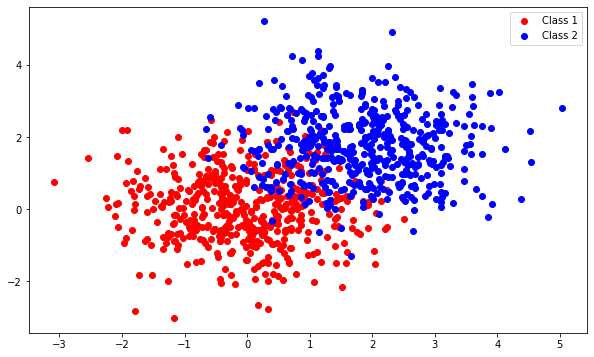

In [3]:
OFFSET = 1.75
X, y = toydata(OFFSET, 1000)

# Visualize the generated data
class1 = y == 1
class2 = y == 2
plt.figure(figsize=(10,6))
plt.scatter(X[class1,0], X[class1,1], c='r', marker='o', label='Class 1')
plt.scatter(X[class2,0], X[class2,1], c='b', marker='o', label='Class 2')
plt.legend();

<h3>Part One: Noise</h3>
<p>First, let's focus on the noise. For this, we compute the expected label for a given input $\mathbf{x}$:

$$\bar y(\mathbf{x})=1*p(y=1\;|\;\mathbf{x})+2*p(y=2\;|\;\mathbf{x})$$

in <strong><code>computeybar</code></strong>. We compute the probability $p(\mathbf{x}|y)$ with the equations $p(\mathbf{x}|y=1)\sim {\mathcal{N}}(0,{I}) \textrm { and } p(\mathbf{x}\;|\;y=2)\sim {\mathcal{N}}(\mathbf{\mu_2},{I})$. Then use Bayes rule to compute</p><br>
$$p(y=1|\mathbf{x})=\frac{p(\mathbf{x}\;|\;y=1)p(y=1)}{p(\mathbf{x}\;|\;y=1)p(y=1)+p(\mathbf{x}\;|\;y=2)p(y=2)}$$

<p><strong>Note:</strong> We use the function <em>`normpdf`</em> to compute $p(\mathbf{x}\;|\;y_i)$, which is defined in <strong><code>computeybar</code></strong> in the following cell. Note that <code>normpdf</code> only computes $p(x\;|\;y)$ in a single dimension, but we can use the fact that both dimensions are independent to obtain for example $p(\mathbf{x}\;|\;y=1)=p(x_1\;|\;y=1)p(x_2\;|\;y=1)$. Remember: class 1 has $\mu=[0;0]^T,\sigma=1$; class 2 has $\mu=[OFFSET;OFFSET]^T,\sigma=1$.
<br/></p>

In [4]:
def computeybar(X_test, OFFSET):
    """
    function [ybar] = computeybar(X_test, OFFSET);
    
    This function computes the expected label 'ybar' for a set of inputs x
    generated from two standard Normal distributions (one offset by OFFSET in both dimensions).
    
    Inputs:
    ------
    X_test : nx2 array of n vectors with 2 dimensions
    OFFSET : The OFFSET passed into the toyData function
    
    Outputs:
    -------
    ybar : a nx1 vector of the expected labels for vectors X_test
    """
    n, d = X_test.shape
    ybar = np.zeros(n)
    
    # the following function computes p(x|y)
    # By default, mean is 0 and std. deviation is 1
    normpdf = lambda x, mu, sigma: np.exp(-0.5 * np.power((x - mu) / sigma, 2)) / (np.sqrt(2 * np.pi) * sigma)
    
    p_x_y1 = normpdf(X_test[:,0], 0, 1) * normpdf(X_test[:,1], 0, 1)
    p_x_y2 = normpdf(X_test[:,0], OFFSET, 1) * normpdf(X_test[:,1], OFFSET, 1)
    
    p_y1_x = p_x_y1 / (p_x_y1 + p_x_y2)
    p_y2_x = p_x_y2 / (p_x_y1 + p_x_y2)
    
    ybar = 1 * p_y1_x + 2 * p_y2_x
    
    return ybar

<p>Now, calculate the noise component $\mathbb{E}[(\bar{y}(\mathbf{x})-y(\mathbf{x}))^2]$ of the error using the results of <strong><code>computeybar</code></strong> implemented above. Remember that $$\mathbb{E}[(\bar{y}(\mathbf{x})-y(\mathbf{x}))^2] = \frac{1}{n}\sum_{i=1}^n(\bar{y}({x_i})-y({x_i}))^2$$
and that <strong><code>computeybar</code></strong> computes $\bar{y}(\mathbf{x}) = [\bar{y}({x_1})\dots \bar{y}({x_n})]$.</p>

In [5]:
def computenoise(X_test, y_test, OFFSET):
    """
    function noise = computenoise(X_test, y_test, OFFSET);
    
    This function computes the noise, or square mean of ybar - y, for a set of inputs x
    generated from two standard Normal distributions (one offset by OFFSET in both dimensions).
    
    Inputs:
    ------
    X_test : nx2 array
    y_test : nx1 array of labels
    OFFSET : The OFFSET passed into the toyData function
    
    Outputs:
    -------
    noise : a scalar representing the noise component of the error of X_test
    """
    ybar = computeybar(X_test, OFFSET)
    n = len(ybar)
    noise = (1 / n) * np.sum(np.power(y_test - ybar, 2))
    
    return noise

<h3>Visualizing the Data</h3>

<p>You can now see the error of the bayes classifier. Below is a plotting of the two classes of points and the misclassified points.</p>

Error of Bayes classifier: 10.60%.
Noise: 0.0755


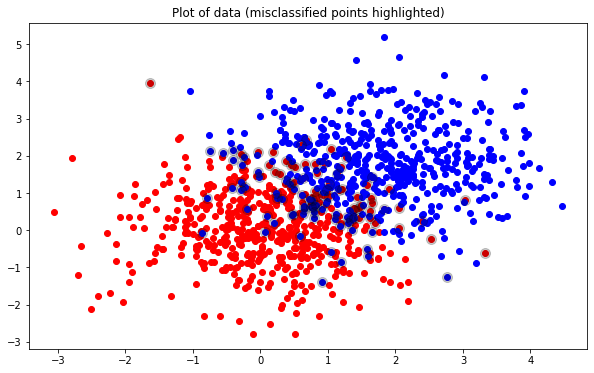

In [6]:
OFFSET = 1.75
np.random.seed(1)
X_test, y_test = toydata(OFFSET, 1000)

# compute Bayes Error
ybar = computeybar(X_test, OFFSET)
predictions = np.round(ybar)
errors = predictions != y_test
error = 100 * errors.sum() / len(y_test)
print('Error of Bayes classifier: %.2f%%.' % error)

# print out the noise
print('Noise: %.4f' % computenoise(X_test, y_test, OFFSET))

# plot data
class1 = y_test == 1
class2 = y_test == 2
plt.figure(figsize=(10,6))
plt.scatter(X_test[class1,0], X_test[class1,1], c='r', marker='o')
plt.scatter(X_test[class2,0], X_test[class2,1], c='b', marker='o')
plt.scatter(X_test[errors,0], X_test[errors,1], c='k', s=100, alpha=0.2)
plt.title("Plot of data (misclassified points highlighted)")
plt.show()

As you can see from the graph above, the dataset is noisy and cannot be classified into two groups cleanly, thus giving nonzero noise and nonzero bayes error!

<h3>Part Two: Bias</h3>

<p>For the bias, we need the average classifier $\bar{h}$. Although we cannot compute the expected value $\bar h\!=\!\mathbb{E}[h]$, we can approximate it by sampling many training sets $D_1, \dots, D_m$ and training a classifier on each, getting $h_{D_1},\dots, h_{D_m}$. We can then average their predictions on each data point:</p> $$\bar{h}(\mathbf{x})\approx \frac{1}{m}\sum_{i=1}^m h_{D_i}(\mathbf{x})$$</p>

We are going to use a regression tree as our $h_D$.

In [7]:
class TreeNode(object):
    
    def __init__(self, left, right, parent, cutoff_id, cutoff_val, prediction):
        self.left = left
        self.right = right
        self.parent = parent
        self.cutoff_id = cutoff_id
        self.cutoff_val = cutoff_val
        self.prediction = prediction

In [8]:
class RegressionTree:
    
    def __init__(self, depth=np.inf, weights=None):
        self.depth = depth
        self.weights = weights
        self.root = None
        
    def fit(self, X_train, y_train):
        self.root = self.cart(X_train, y_train, self.depth, self.weights)
        
    def predict(self, X_train):
        if self.root is None:
            raise NotImplementedError('The tree is not fitted yet!')
            
        return self.evaltree(self.root, X_train)
    
    def sqsplit(self, X_train, y_train, weights=None):
        """
        This method finds the best feature, cut value, and loss value.
        
        Inputs:
        ------
        X_train : n x d matrix of data points
        y_train : n-dimensional vector of labels
        weights : n-dimensional weight vector for data points
        
        Outputs:
        -------
        feature  : index of the best cut's feature
        cut      : cut-value of the best cut
        bestloss : loss of the best cut
        """
        N, D = X_train.shape
        assert D > 0 # must have at least one dimension
        assert N > 1 # must have at least two samples
        if weights is None: # if no weights are passed on, assign uniform weights
            weights = np.ones(N)
            
        weights = weights / sum(weights) # normalize weights
        bestloss = np.inf
        feature = np.inf
        cut = np.inf
        
        # Begin Solution
        for d in range(D):
            ii = X_train[:,d].argsort() # sort data along dimensions
            xs = X_train[ii,d]          # sorted feature values
            ws = weights[ii]            # sorted weights
            ys = y_train[ii]            # sorted labels
            
            # Initialize constants
            sL  = 0.0             # mean squared label on left side
            muL = 0.0             # mean label on left side
            wL  = 0.0             # total weight on left side
            sR  = ws.dot(ys ** 2) # mean squared label on right 
            muR = ws.dot(ys)      # mean label on right
            wR  = sum(ws)         # weight on right
            
            pj = 0 # index counter
            idif = np.where(np.abs(np.diff(xs, axis=0)) > np.finfo(float).eps * 100)[0]
            for j in idif:
                deltas  = np.dot(ys[pj:j+1] ** 2, ws[pj:j+1])
                deltamu = np.dot(ws[pj:j+1], ys[pj:j+1])
                deltaw  = np.sum(ws[pj:j+1])
                
                sL  += deltas
                muL += deltamu
                wL  += deltaw
                
                sR  -= deltas
                muR -= deltamu
                wR  -= deltaw
                
                L = sL - muL ** 2 / wL
                R = sR - muR ** 2 / wR
                loss = L + R
                
                if loss < bestloss:
                    feature = d
                    cut = (xs[j] + xs[j+1]) / 2
                    bestloss = loss
                pj = j + 1
                
        assert feature != np.inf and cut != np.inf
        
        return feature, cut, bestloss
    
    def cart(self, X_train, y_train, depth=np.inf, weights=None):
        """
        This method builds a CART tree.
        
        The maximum tree depth is defined by "maxdepth" (maxdepth=2 means one split).
        Each example can be weighted with "weights".
        
        Inputs:
        ------
        X_train  : n x d matrix of data
        y_train  : n-dimensional vector
        maxdepth : maximum tree depth
        weights  : n-dimensional weight vector for data points
        
        Outputs:
        -------
        tree : root of decision tree
        """
        n, d = X_train.shape
        if weights is None:
            w = np.ones(n) / float(n)
        else:
            w = weights
        
        # Begin Solution
        index = np.arange(n)
        prediction = y_train.dot(w) / float(np.sum(w))
        if depth == 0 or np.all(y_train == y_train[0]) or np.max(np.abs(np.diff(X_train, axis=0))) < (np.finfo(float).eps * 100):
            # Create leaf Node
            return TreeNode(None, None, None, None, None, prediction)
        else:
            feature, cut, h = self.sqsplit(X_train, y_train, w)
            left_idx = index[X_train[:,feature] <= cut]
            right_idx = index[X_train[:,feature] > cut]
            left_w = w[left_idx]
            right_w = w[right_idx]
            left = self.cart(X_train[left_idx,:], y_train[left_idx], depth=depth-1, weights=left_w)
            right = self.cart(X_train[right_idx,:], y_train[right_idx], depth=depth-1, weights=right_w)
            currNode = TreeNode(left, right, None, feature, cut, prediction)
            left.parent  = currNode
            right.parent = currNode
            
            return currNode
        
    def evaltree(self, root, X_test, idx=[]):
        """
        This method evaluates test data using the decision tree root.
        
        Inputs:
        ------
        root   : TreeNode decision tree
        X_test : n x d matrix of data points
        
        Outputs:
        -------
        pred: n-dimensional vector of predictions
        """
        assert root is not None
        n = X_test.shape[0]
        pred = np.zeros(n)
        
        if len(idx) == 0:
            idx = np.ones(n) == 1
            
        if root.left is None and root.right is None:
            return np.ones(sum(idx)) * root.prediction
        
        assert root.left is not None and root.right is not None
        feature, cutoff = root.cutoff_id, root.cutoff_val
        
        idxL = idx & (X_test[:,feature] <= cutoff)
        if root.left.left == None and root.left.right == None:
            pred[idxL] = root.left.prediction
        else:
            pred[idxL] = self.evaltree(root.left, X_test, idxL)
            
        idxR = idx & (X_test[:,feature] > cutoff)
        if root.right.left == None and root.right.right == None:
            pred[idxR] = root.right.prediction
        else:
            pred[idxR] = self.evaltree(root.right, X_test, idxR)
            
        return pred[idx]

In [9]:
def computehbar(X_test, depth, Nsmall, NMODELS, OFFSET):
    """
    function [hbar] = computehbar(X_test, depth, NSmall, NMODELS, OFFSET);

    This function computes the expected prediction of the average regression tree (hbar) for data set X_test.
    The regression tree should be trained using data of size Nsmall and is drawn from toydata with OFFSET.
    The "infinite" number of models is estimated as an average over NMODELS.
    
    Inputs:
    ------
    X_test  : nx2 matrix
    depth   : Depth of the tree
    Nsmall  : Number of points to subsample
    NMODELS : Number of Models to average over
    OFFSET  : The OFFSET passed into the toyData function
    
    Outputs:
    -------
    hbar : nx1 vector with the predictions of hbar for each test input
    """
    n = X_test.shape[0]
    hbar = np.zeros(n)
    
    for _ in range(NMODELS):
        X_train, y_train = toydata(OFFSET, Nsmall)
        model = RegressionTree(depth=depth)
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        hbar += pred
    
    return hbar / NMODELS

<h4>Bias Continued</h4>

Now, we're equipped to calculate the bias $\mathbb{E}[(\bar{h}(\mathbf{x})-\bar{y}(\mathbf{x}))^2]$. In this case, we need to compute the mean of the squared difference over your input points:
$$\mathbb{E}[(\bar{h}(\mathbf{x})-\bar{y}(\mathbf{x}))^2] = \frac{1}{n}\sum_{i=1}^n(\bar{h}({x_i})-\bar{y}({x_i}))^2$$

In [10]:
def computebias(X_test, depth, Nsmall, NMODELS, OFFSET):
    """
    function bias = computebias(X_test, depth, NSmall, NMODELS, OFFSET);
    
    This function computes the bias for data set X_test.
    The regression tree should be trained using data of size Nsmall and is drawn from toydata with OFFSET.
    The "infinite" number of models is estimated as an average over NMODELS.
    
    Inputs:
    ------
    X_test  : nx2 matrix
    depth   : Depth of the tree
    Nsmall  : Number of points to subsample
    NMODELS : Number of Models to average over
    OFFSET  : The OFFSET passed into the toyData function
                    
    Outputs:
    -------
    bias : a scalar representing the bias of the input data
    """
    ybar = computeybar(X_test, OFFSET)
    hbar = computehbar(X_test, depth, Nsmall, NMODELS, OFFSET)
    bias = np.mean(np.power(hbar - ybar, 2))
    
    return bias

<h3>Part Three: Variance</h3>

<p>Finally, to compute the variance, we need to compute the term $\mathbb{E}[(h_D-\bar{h})^2]$. We will calculate it directly by editing <strong><code>computevariance</code></strong>.

We can approach this calculation by first considering $\bar{v}(\mathbf{x}) = (h_D(\mathbf x)-\bar{h} ( \mathbf x))^2$. Once again, we cannot compute the expected value exactly, but we can approximate this term by averaging over <code>NMODELS</code> models. We can use our previous function to compute $\bar{h}$, and then estimate
$$\bar{v}(\mathbf{x})=\mathbb{E}_D[(h_D(\mathbf{x})-\bar{h}(\mathbf{x}))^2]\approx \frac{1}{m}\sum_{j=1}^m(h_{D_j}(\mathbf{x_i})-\bar{h}(\mathbf{x_i}))^2$$
where once again $D_1,\dots,D_m$ are i.i.d. training data sets. Note that the output of this function is a vector; in other words, we should not be taking an average over the $n$ input points.
</p>

Finally, we will need to return the variance itself, which is $$\mathbb{E}[(h_D(\mathbf{x})-\bar{h}(\mathbf{x}))^2] = \mathbb{E}[\bar{v}(\mathbf{x})] = \frac{1}{n}\sum_{i=1}^n \bar{v}({x}_i)$$

In [11]:
def computevariance(X_test, depth, hbar, Nsmall, NMODELS, OFFSET):
    """
    function variance = computevbar(X_test, depth, hbar, Nsmall, NMODELS, OFFSET)
    
    This function computes the variance of classifiers trained on data sets from
    toydata with pre-specified "OFFSET" and with kernel regression evaluated on X_test.
    The prediction of the average classifier is assumed to be stored in "hbar".
    The "infinite" number of models is estimated as an average over NMODELS.
    
    Inputs:
    ------
    X_test  : nx2 matrix
    depth   : Depth of the tree
    hbar    : nx1 vector of the predictions of hbar on the inputs X_test
    Nsmall  : Number of points to subsample
    NMODELS : Number of Models to average over
    OFFSET  : The OFFSET passed into the toyData function
    
    Outputs:
    -------
    vbar : nx1 vector of the difference between each model prediction and the average model prediction for each input
    """
    n = X_test.shape[0]
    vbar = np.zeros(n)
    variance = 0
    
    for _ in range(NMODELS):
        X_train, y_train = toydata(OFFSET, Nsmall)
        model = RegressionTree(depth=depth)
        model.fit(X_train, y_train)
        hd = model.predict(X_test)
        vbar += np.power(hbar - hd, 2)
        
    vbar = vbar / NMODELS
    variance = np.mean(vbar)
    
    return variance

<h3>Review the Error for Various Depths</h3>

<p>See how the error decomposes (roughly) into bias, variance and noise for various depths.</p>

In [12]:
# bias variance demo
OFFSET = 1.75

# training set size
Nsmall = 75

# how big is a really big data set (approx. infinity)
Nbig = 7500

# models to average
NMODELS = 100

# What regularization constants to evaluate
depths = [0, 1, 2, 3, 4, 5, 6, np.inf]

Ndepths = len(depths)
lbias = np.zeros(Ndepths)
lvariance = np.zeros(Ndepths)
ltotal = np.zeros(Ndepths)
lnoise = np.zeros(Ndepths)
lsum = np.zeros(Ndepths)

# Different regularization constant classifiers
for i in range(Ndepths):
    depth = depths[i]
    # use this data set as an approximation of the true test set
    X_test, y_test = toydata(OFFSET, Nbig)
    
    # Estimate AVERAGE ERROR (TOTAL)
    total = 0
    for j in range(NMODELS):
        # Set the seed for consistent behavior
        X_train2, y_train2 = toydata(OFFSET, Nsmall)
        model = RegressionTree(depth=depth)
        model.fit(X_train2, y_train2)
        total += np.mean((model.predict(X_test) - y_test) ** 2)
        
    total /= NMODELS
    
    # Estimate Noise
    noise = computenoise(X_test, y_test, OFFSET)
    
    # Estimate Bias
    bias = computebias(X_test, depth, Nsmall, NMODELS, OFFSET)
    
    # Estimate VARIANCE
    hbar = computehbar(X_test, depth, Nsmall, NMODELS, OFFSET)
    variance = computevariance(X_test, depth, hbar, Nsmall, NMODELS, OFFSET)
    
    # print and store results
    lbias[i] = bias
    lvariance[i] = variance
    ltotal[i] = total
    lnoise[i] = noise
    lsum[i] = lbias[i] + lvariance[i] + lnoise[i]
    
    if np.isinf(depths[i]):
        print('Depth infinite: Bias: %2.4f Variance: %2.4f Noise: %2.4f Bias+Variance+Noise: %2.4f Test error: %2.4f'
          % (lbias[i], lvariance[i], lnoise[i], lsum[i], ltotal[i]))
    else:
        print('Depth: %d: Bias: %2.4f Variance: %2.4f Noise: %2.4f Bias+Variance+Noise: %2.4f Test error: %2.4f'
          % (depths[i], lbias[i], lvariance[i], lnoise[i], lsum[i], ltotal[i]))

Depth: 0: Bias: 0.1713 Variance: 0.0000 Noise: 0.0795 Bias+Variance+Noise: 0.2507 Test error: 0.2500
Depth: 1: Bias: 0.0296 Variance: 0.0573 Noise: 0.0789 Bias+Variance+Noise: 0.1659 Test error: 0.1650
Depth: 2: Bias: 0.0049 Variance: 0.0394 Noise: 0.0747 Bias+Variance+Noise: 0.1190 Test error: 0.1204
Depth: 3: Bias: 0.0035 Variance: 0.0473 Noise: 0.0766 Bias+Variance+Noise: 0.1274 Test error: 0.1249
Depth: 4: Bias: 0.0023 Variance: 0.0681 Noise: 0.0739 Bias+Variance+Noise: 0.1444 Test error: 0.1414
Depth: 5: Bias: 0.0023 Variance: 0.0808 Noise: 0.0815 Bias+Variance+Noise: 0.1646 Test error: 0.1624
Depth: 6: Bias: 0.0024 Variance: 0.0829 Noise: 0.0759 Bias+Variance+Noise: 0.1612 Test error: 0.1610
Depth infinite: Bias: 0.0028 Variance: 0.0897 Noise: 0.0774 Bias+Variance+Noise: 0.1699 Test error: 0.1698


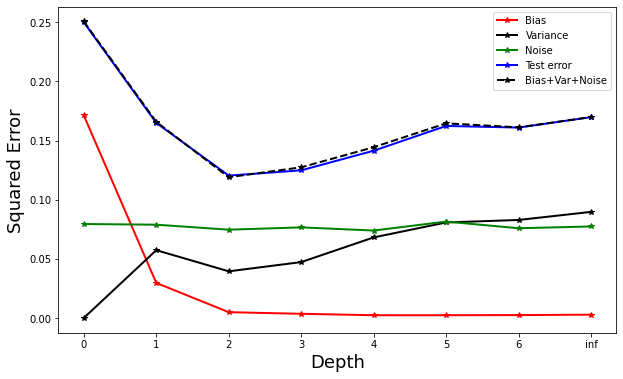

In [13]:
# plot results
plt.figure(figsize=(10,6))
plt.plot(lbias[:Ndepths], '*', c='r', linestyle='-', linewidth=2)
plt.plot(lvariance[:Ndepths], '*', c='k', linestyle='-', linewidth=2)
plt.plot(lnoise[:Ndepths], '*', c='g', linestyle='-', linewidth=2)
plt.plot(ltotal[:Ndepths], '*', c='b', linestyle='-', linewidth=2)
plt.plot(lsum[:Ndepths], '*', c='k', linestyle='--', linewidth=2)

plt.legend(["Bias", "Variance", "Noise", "Test error", "Bias+Var+Noise"]);
plt.xlabel("Depth", fontsize=18);
plt.ylabel("Squared Error", fontsize=18);
plt.xticks([i for i in range(Ndepths)], depths);